In [58]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Prepare for Dataset

In [59]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('../Data/shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [60]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [61]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [62]:
class Net(nn.Module):
    def __init__(self,layers):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        self.layers = layers
        
        self.rnn = nn.RNN(self.input_size,self.hidden_size,self.layers) 
        self.output_layer = nn.Linear(self.hidden_size,self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        output,hidden = self.rnn(input,hidden)
        output = self.output_layer(output)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(self.layers, self.hidden_size).to(device) 
    
net = Net(layers=4)     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNN(100, 100, num_layers=4)
  (output_layer): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [63]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [64]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [65]:
# Number of iterations.
iters       = 20000  # Number of training iterations.
print_iters = 200    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:3.4047441482543945
generated sequence: Wes n
ueVodo  o
aew a 
riym,h
nk.v o
 sssIso
vK  lrolcaIo k

b
dsAhui oear oceo rIo ccyId  wBr fba,hn

iter:399/20000 loss:3.4030632972717285
generated sequence: WPbfAsHtrretlr: dreeea tcnt? ,hny 'gyEsothnndldbtslateh nlc isdrtbnehsreihidhAflotwssnuhlsia es,seyar

iter:599/20000 loss:3.3505373001098633
generated sequence: WtpteItae heIe sryhbkert tieu tmdeh,ulh  b fshtnElhd a  Ihrl eWer  emhmyuin
o do rt hg esflt n
At  he

iter:799/20000 loss:3.3830482959747314
generated sequence: W,dung h hamtoebvot,rNyI eA sbiyfyhueN
an  rVt
,wItutn,h    fhotT ahrgithesSo pO, trtoecniS o th
r
tW

iter:999/20000 loss:3.399160861968994
generated sequence: W wedtem  eou
,uere:h rmpioby
udEdreH
 l s
 seaeeo oy o,fpca eLre;h
r n
mnmiteefafuEe sfie snoioe iee

iter:1199/20000 loss:3.364819049835205
generated sequence: Wol  nsfo  tyT houwJvsoyeugahe nnio 'rhc,s sgid nr?n!irsnbtnyu ?ha scaniictdnndW htnthirdttnnMdams ny

iter:1399/20000 loss:3.371074

#### Training Loss Curve

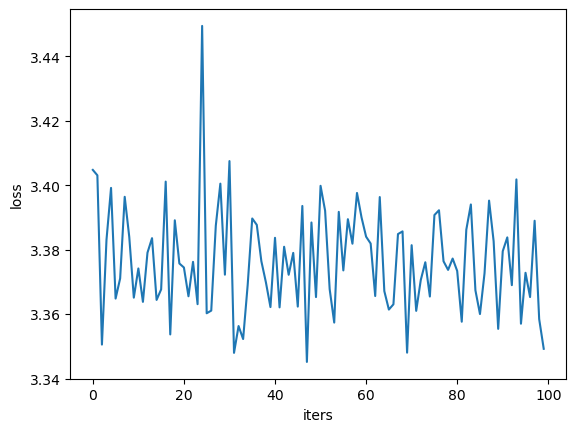

In [66]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss.item() for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [67]:
print(eval_step(net, predicted_len=600))

Woea taeEi  oe.yotI Yrre nRsmsl' e
 cprUlrto   thietDyh
e,AtpLhv ee
 eghyu.rvewr,davyhrea
thtt oh
oroI  rsm S
re psEM ,s r
rry h
eeesntBt s-'N E o
utt
  I w evynen ydyels oe
p
n.K Lu,
h
E Nste ho n!ace sw
Eay
.nenO.ylYrore  tnoeh  HkMu od:,IOWef '
fvvo 
Rrti:gno h hyUYov:LKs'b
afs!eie
emu: en H
eeffee adeN anthr :
'crb oto e p eeohIrvtran sa otnSdon!ere yava yOrtrl ogRrrerhE.eoUs crre
   'yais e eootahir;a
oIm Amn rm r
h  xh C-; 
rteee d veasyshheyd isvNas .
  trs' e, Ta
hddnUb. s eol h:hgsh onfdIeCS GeN
oeenr EaAbm  Sho  napZsoaMenhoh mrakp
euH  e hV? d yegDrasyoh,nuPu h rrh
nI.:s:h didpa, ee 


### Method
It turns out that my first method of adding more layers was incorrect. Instead of alternating between the input and output layers, I also attempted to simply add more hidden layers followed by one ouput layer, but after asking chat gpt, I was told to use RNN instead of RNNCell. After reading torch's documentation, this seems correct.

Details: Changed from rnncell to rnn and specified layers. For the forward method, I only needed to include the self.rnn and the nn.linear. Based on the documentation, the hidden state computes the following

$$
h_{t} = \text{tanh}(x_{t}W_{ih}^{T} + b_{ih} + h_{t-1}W_{hh}^{T} + b_{hh})
$$

This change also required that we change the dimensions of  init_hidden(self) method from 
torch.zeros(1, self.hidden_size) to torch.zeros(self.layers, self.hidden_size) because we are now creating a multi layered rnn. Some of the suggestions I edited while others I had to rely on chat gpt's example given here: https://chatgpt.com/c/48efeda3-69a1-4dcb-b5e6-c17c4086707a.

### Evaluation
Surprisingly, a multi layered recurrent network did not yield desirable results in terms of training loss and sensible output produced.
